In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
from PIL import Image
from transformers import AutoImageProcessor, AutoModel
import pandas as pd
import mediapipe as mp
from tqdm import tqdm
import os

# change entry point to project root
%cd ..

from third_party.FastSAM.Inference import segment

c:\Users\arshs\miniconda3\envs\dlproj\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\arshs\OneDrive\Documents\GitHub\mimic


In [3]:
def create_mask_images(original_image, masks):
    original_image_array = np.array(original_image)
    all_cropped_imgs = []

    for i in range(masks.shape[0]):
        mask = masks[i, :, :]
        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(mask)
        np_mask = mask.unsqueeze(dim=2).numpy()
        masked_img = (original_image_array * np_mask).astype(np.uint8)  # Convert to uint8
        ys, xs = np.where(mask)
        if ys.size == 0 or xs.size == 0:
            continue
        bbox = np.min(xs), np.min(ys), np.max(xs), np.max(ys)
        cropped_image_array = masked_img[bbox[1]:bbox[3]+1, bbox[0]:bbox[2]+1, :]
        cropped_image_pil = Image.fromarray(cropped_image_array)
        all_cropped_imgs.append(cropped_image_pil)

    return all_cropped_imgs

In [4]:
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')

c:\Users\jackh\Code\personal\mimic\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
def get_obj_masks(img_path, point="[[0,0]]", point_label="[0]", text_prompt=None, filter=True):
    segs = segment(img_path, point_prompt=point, point_label=point_label, text_prompt=text_prompt, filter=filter)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(segs.shape)
    return segs


In [6]:
def get_obj_embeddings(img_path, masks):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cropped_objs = create_mask_images(image, masks)

    if len(cropped_objs) != 0:
        inputs = processor(images=cropped_objs, return_tensors="pt")
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        # cls_embeddings = last_hidden_states[:, 0, :].squeeze()
        cls_embeddings = last_hidden_states

        return cls_embeddings
    
    return None

In [9]:
def get_frame_point(videoPath, out=False):
    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=False,
                        max_num_hands=2,
                        min_detection_confidence=0.5,
                        min_tracking_confidence=0.5)
    mp_drawing = mp.solutions.drawing_utils

    centers = [[], []]
    wrists = [[], []]
    finger_pts = [[], []]

    # Function to calculate standard deviation of distances
    def calculate_stdev(coordinates):
        distances = np.linalg.norm(coordinates - np.mean(coordinates, axis=0), axis=1)
        stdev = np.std(distances)
        return stdev

    # Function to draw a circle on the frame
    def draw_circle(frame, center, RED=1):
        cv2.circle(frame, center, 20, (0, 255*RED, 255*(1-RED)), -1)
        
    def extract_hand_data(frame):
        results = hands.process(frame)
        # print(results.multi_hand_world_landmarks)

        if results.multi_hand_world_landmarks:
            for hand in results.multi_handedness:
                # Get a constant index for the detected hand (0 or 1). If only 1 hand is detected, default to index = 0.
                hand_idx = hand.classification[0].index
                try:
                    hand_landmarks = results.multi_hand_landmarks[hand_idx]
                except:
                    hand_idx = 0
                    hand_landmarks = results.multi_hand_landmarks[0]
                
                # Get key points on palm
                # palm_points = np.asarray([[hand_landmarks.landmark[12].x, hand_landmarks.landmark[12].y, hand_landmarks.landmark[12].z], 
                #                         [hand_landmarks.landmark[16].x, hand_landmarks.landmark[16].y, hand_landmarks.landmark[16].z], 
                #                         [hand_landmarks.landmark[20].x, hand_landmarks.landmark[20].y, hand_landmarks.landmark[20].z],
                #                         [hand_landmarks.landmark[4].x, hand_landmarks.landmark[4].y, hand_landmarks.landmark[4].z],
                #                         [hand_landmarks.landmark[8].x, hand_landmarks.landmark[8].y, hand_landmarks.landmark[8].z]])
                palm_points = np.asarray([
                        [hand_landmarks.landmark[4].x, hand_landmarks.landmark[4].y, hand_landmarks.landmark[4].z],
                        [hand_landmarks.landmark[8].x, hand_landmarks.landmark[8].y, hand_landmarks.landmark[8].z]])

                # Get palm orientation by calculating normal vector of palm plane
                # normal_vector = np.cross(palm_points[2] - palm_points[0], palm_points[1] - palm_points[2])
                # normal_vector /= np.linalg.norm(normal_vector)
                # orientations[hand_idx].append(normal_vector)

                # both contact points
                finger_tips = np.copy(palm_points)
                finger_tips[:, 0] *= frame.shape[1]
                finger_tips[:, 1] *= frame.shape[0]
                finger_pts[hand_idx].append(finger_tips)

                # Get hand center
                palm_points_mean = np.mean(palm_points, axis=0)
                center_x = int(palm_points_mean[0] * frame.shape[1])
                center_y = int(palm_points_mean[1] * frame.shape[0])
                centers[hand_idx].append((center_x, center_y))
            
                wrist_center_x = int(hand_landmarks.landmark[0].x * frame.shape[1])
                wrist_center_y = int(hand_landmarks.landmark[0].y * frame.shape[0])
                wrists[hand_idx].append((wrist_center_x, wrist_center_y))
                # cv2.circle(frame, (center_x, center_y), 3, (255, 0, 0))
            # for x in range(2):
            #     # Draw current & past hand centers on existing frame
            #     cv2.polylines(frame, [np.array(centers[x])], False, (0,255*(1-x),255*x), 3)
            
        return frame

    # Open video capture
    cap = cv2.VideoCapture(videoPath)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))


    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    if out:
        out = cv2.VideoWriter(
            os.path.join(f"out.mp4"),
            cv2.VideoWriter_fourcc(*"mp4v"),
            fps, (frame_width, frame_height)
        )

    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()

    # Parameters
    window_size = 20
    stdev_threshold = 5
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    # Initialize variables
    centers_window = [[],[]]

    on = [False, False]
    ret_frame_point = [] #frame, hand1_point, hand2_point
    for x in tqdm(range(num_frames)):
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Get hand center coordinates
        frame = extract_hand_data(frame)
        frame_level = []
        # print(centers)
        for h in range(2):
            hand_center = centers[h][-1] if len(centers[h]) > 0 else None
            # print(hand_center)

            if hand_center is not None:
                # Add hand center to the window
                centers_window[h].append(hand_center)

                # Keep the window size limited to the last 20 frames
                if len(centers_window[h]) > window_size:
                    centers_window[h].pop(0)

                # Calculate standard deviation of distances
                if len(centers_window[h]) == window_size:
                    stdev = calculate_stdev(np.array(centers_window[h]))

                    # Check if stdev is below the threshold
                    if stdev < stdev_threshold:
                        if not on[h]:
                            on[h]=True
                            # Draw a circle on the frame at the average center
                            average_center = tuple(centers_window[h][-1]) #tuple(np.mean(centers_window, axis=0).astype(int))
                            frame_level.append((x,average_center, wrists[h][-1], finger_pts[h][-1]))
                            draw_circle(frame, average_center, RED=h)
                    else:
                        on[h]=False
        if frame_level:
            ret_frame_point.append(frame_level)


        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # Display the frame
        if out:
            out.write(frame)

        # Exit when 'q' key is pressed
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

    # Release video capture
    if out:
        out.release()
    cap.release()
    cv2.destroyAllWindows()
    return ret_frame_point

In [10]:
frames = get_frame_point("segmentation/videos/IMG_3288.MOV")

  0%|          | 0/511 [00:00<?, ?it/s]c:\Users\arshs\miniconda3\envs\dlproj\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
100%|██████████| 511/511 [00:42<00:00, 12.11it/s]


In [11]:
print(frames)

[[(19, (1497, 308), (1477, 235), array([[       1487,      310.21,   -0.094682],
       [     1508.3,      306.86,   -0.080701]])), (19, (579, 372), (581, 322), array([[     587.34,      381.46,   -0.091256],
       [      571.8,      363.21,   -0.089046]]))], [(128, (330, 731), (364, 381), array([[     378.93,      716.66,   -0.081234],
       [     282.49,      746.04,   -0.077105]]))], [(228, (1701, 600), (1723, 280), array([[     1581.8,      565.52,    -0.12507],
       [     1820.9,      634.78,    -0.14497]]))], [(368, (1156, 411), (1300, 307), array([[     1128.8,      377.01,    -0.10917],
       [     1183.5,      446.51,    -0.18401]]))], [(405, (1020, 332), (870, 231), array([[       1016,      300.99,   -0.074892],
       [     1025.7,      363.49,    -0.12583]]))], [(407, (1151, 434), (1295, 329), array([[     1124.3,      403.31,    -0.10913],
       [     1179.4,      466.23,    -0.18314]]))], [(420, (1148, 441), (1298, 335), array([[     1123.5,      412.64,   -0.09722

In [12]:
def save_frame_as_image(video_path, frame_number, save_path, point=None, radius=5, color=(0, 255, 0), thickness=-1):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    
    # cv2.circle(frame, (int(point[0, 0]), int(point[0, 1])), radius, (0, 255, 0), thickness)
    # cv2.circle(frame, (int(point[1, 0]), int(point[1, 1])), radius, (255, 0, 0), thickness)
    cv2.imwrite(save_path, frame)

    return frame

In [13]:
def sort_masks_by_interaction(finger_point, masks):
    interactions = []

    for mask in masks:
        ys, xs = np.where(mask)
        x_min, y_min, x_max, y_max = np.min(xs), np.min(ys), np.max(xs), np.max(ys)
        center = torch.tensor([(x_min + x_max) / 2, (y_min + y_max) / 2])
        distance = torch.norm(finger_point - center)
        mask_area = torch.sum(mask)
        image_area = mask.shape[0] * mask.shape[1]

        print(mask_area/image_area)
        
        interactions.append((distance, mask))

    sorted_interactions = sorted(interactions, key=lambda x: x[0])
    sorted_masks = torch.stack([mask for _, mask in sorted_interactions])
    return sorted_masks

In [14]:
from scipy.ndimage import distance_transform_edt

def closest_pt_to_mask(point, mask, crop_transform=False):
    mask = mask.squeeze().numpy()
    dist_transform, indices = distance_transform_edt(1 - mask, return_indices=True)
    closest_point = [indices[1, point[1], point[0]], indices[0, point[1], point[0]]]

    if crop_transform:
        ys, xs = np.where(mask)
        x_min, y_min = np.min(xs), np.min(ys)
        closest_point[0] = closest_point[0] - x_min
        closest_point[1] = closest_point[1] - y_min

    return tuple(closest_point)


In [12]:
hands_embedding = torch.tensor([[ 3.2411e-01, -2.1681e+00,  6.7837e-01, -1.2314e+00,  1.1895e+00,  8.3687e-01,  1.9515e+00, -2.3028e+00,  9.3972e-01,  3.0057e+00,  9.2657e-01, -8.1075e-01, -7.0905e-01,  1.8354e-01,  6.2937e-01,  6.2842e-02, -6.3435e-01, -2.8827e-01,  1.2249e+00,  1.8282e+00,  5.6410e-01,  1.7955e-01, -3.3195e-01, -2.8224e-01,
        -1.1176e+00, -1.2011e+00,  2.2813e-02, -1.5000e+00,  1.6296e+00, -1.5399e-01, -5.3223e-01,  1.0544e-01, -6.5583e-01,  2.1421e+00,  1.4926e+00, -1.1805e+00, -1.0050e+00, -1.8420e+00,  2.6674e-01,  6.8551e-02, -1.4262e+00, -1.3507e+00,  1.6418e+00, -1.3655e+00,  1.0930e-01,  9.7874e-02, -2.5370e-02,  1.1901e+00,
         3.3288e+00, -2.3771e-01, -2.0111e+00, -5.5684e-01,  9.8969e-01, -1.9814e-01,  9.5827e-01,  6.9003e-01, -5.4923e-01, -8.4756e-02,  2.0632e-01, -1.1578e+00, -1.4380e+00,  1.1554e+00, -1.1378e+00,  5.0315e-04, -1.3096e+00, -2.4085e+00,  1.4264e+00, -3.3590e-01, -8.7585e-02, -9.5036e-01, -9.1671e-01,  5.9232e-01,
        -1.8510e+00,  5.9307e-01, -8.7356e-01,  1.5989e+00, -4.5739e-01,  1.2219e+00,  6.6144e-01, -1.2515e+00,  1.4503e+00, -1.9482e-01, -1.0404e-02,  4.6862e-02, -1.8080e+00,  1.2675e+00,  3.8622e-01, -3.2221e-01,  1.5700e+00,  5.9247e-01, -4.7869e-01, -2.0900e+00,  1.2445e+00, -1.2005e+00, -1.4438e+00, -5.0345e-01,
         2.1607e+00,  2.6253e+00,  1.5727e+00, -2.8638e-01, -1.5582e+00, -9.8024e-01,  1.6116e-01, -6.5585e-01,  3.2839e-01,  2.3791e+00,  5.7010e-01,  1.1555e+00, -4.8677e-01, -2.7211e+00, -1.7679e+00,  8.9485e-01,  1.3345e+00,  1.0046e+00, -1.4852e+00,  2.0078e-01,  4.3482e-01, -1.8217e-01,  5.0552e-01,  2.0166e+00,
        -1.4462e-01, -1.3129e-01, -7.4878e-01, -5.8600e-01, -1.2357e+00,  8.3569e-01,  1.6505e+00,  8.5869e-01,  1.2038e+00,  2.0170e-01,  2.9991e-01,  1.7936e+00, -3.0676e-01, -1.2859e+00, -3.2538e+00,  1.4357e+00, -1.1952e+00, -1.8953e+00, -1.4882e+00, -1.3803e+00, -1.0789e+00, -1.9991e+00,  8.4532e-01, -5.5771e-01,
        -8.7678e-01,  9.3034e-01,  2.5241e+00, -3.1804e-01, -2.6129e+00, -1.5832e+00, -2.7254e-03,  3.3832e-01, -9.9257e-01,  2.4098e-01, -2.4985e-01,  1.5377e+00,  9.0566e-01,  2.6916e+00,  1.1459e-01, -7.2452e-03,  1.1422e+00, -2.3606e+00,  1.1921e+00, -4.4865e-01,  4.4330e-01, -5.8229e-01, -3.0379e-01, -4.0121e+00,
        -1.5451e+00,  6.3783e-01, -9.2284e-01,  5.5509e-01, -1.3511e+00, -1.1861e+00, -7.3576e-01,  7.2370e-01,  1.2299e+00,  1.1603e+00, -6.9759e-01, -1.2722e-01,  7.6156e-01,  1.7195e+00,  2.8708e-01, -2.6070e-01, -1.6232e+00, -2.4937e+00, -9.1341e-01, -3.4144e-01,  1.4087e+00,  6.5109e-01,  2.6332e-01, -2.3498e+00,
        -1.0552e+00,  7.4124e-01,  2.3968e+00,  8.5681e-01, -3.8004e-01, -2.4869e+00,  1.3096e-01, -3.2389e+00, -1.9059e+00, -4.4069e-01,  7.1492e-01, -1.1676e+00, -1.2429e+00,  1.9352e+00,  5.9151e-02, -7.1631e-01,  2.5063e+00, -3.6717e+00, -2.2320e+00, -1.4058e-01, -9.9184e-01, -3.5773e+00, -3.1908e-01, -1.4831e+00,
        -7.9779e+00, -1.2004e+00,  9.3624e-01, -7.1512e-01, -6.2480e-01,  6.1385e-01,  2.2175e+00, -1.4499e+00,  1.9131e+00,  3.3865e+00, -4.1391e-01,  1.8603e+00,  1.9187e+00,  2.7514e-01,  4.5995e-01, -1.6423e+00, -1.8509e-01,  8.8547e-01, -2.2797e-02,  7.6586e-01,  1.9594e+00, -9.9379e-01,  1.6873e+00, -8.3255e-01,
         3.2816e-01,  8.6717e-02, -9.0111e-01, -2.4524e+00, -1.0931e+00,  9.5315e-01, -1.1662e+00,  1.6471e+00,  1.0608e+00, -3.4149e-02, -1.6259e+00,  4.9189e-01,  2.9139e-02, -4.5185e-01, -9.0051e-01,  2.3195e-01, -9.9271e-01,  7.8550e-02, -1.2881e-01, -1.4385e+00,  1.7829e+00, -1.9669e-01, -2.1443e+00, -5.3220e-01,
        -1.1050e-02, -2.2504e+00,  1.6219e+00, -9.1648e-01, -6.1321e-01,  7.3800e-01, -2.4321e-01, -1.6459e+00,  2.2750e+00,  1.0712e-01, -1.4997e+00,  2.6757e+00, -1.2478e+00, -6.3305e-01,  2.7408e-01, -4.2297e-01, -7.0014e-01,  7.9533e-01,  6.7390e-01, -2.6595e-01,  1.1264e+00,  3.0146e+00,  3.4076e-01, -3.2039e-01,
         2.8426e-01,  4.2236e-01,  6.5239e-02,  3.6244e-01,  8.2800e-01,  1.0296e-01, -1.2000e+00, -1.8898e-01, -4.6246e-01, -1.0559e+00, -3.8730e-01, -1.1654e+00, -1.5572e+00, -3.2377e+00, -6.5258e-01, -1.4038e-01,  1.8404e+00,  1.1481e+00, -1.6165e-01,  1.7551e+00, -3.3809e-01, -1.0164e+00, -2.1922e+00,  2.1463e+00,
        -1.9060e+00,  1.3726e+00, -7.0967e-02,  5.3278e-03,  1.0935e-01, -1.6284e+00,  4.0053e-01,  5.5357e-02,  2.6584e-01,  6.3773e-01,  2.9415e-01,  1.0529e+00, -6.0284e-01, -7.3852e-01,  3.2759e-01, -5.6463e-01,  4.2310e-01,  4.6281e-01,  2.3820e+00,  2.8018e-01,  1.0416e+00, -1.4180e+00,  2.5398e+00,  1.4631e-02,
        -1.6736e+00,  1.2964e+00,  1.5471e+00,  5.2596e-01,  1.7086e+00, -9.0946e-01,  2.7273e-01, -1.3403e+00, -1.9679e+00,  3.9582e-01, -8.2888e-01,  1.2450e-01,  6.0270e-01, -2.2608e+00,  5.3788e-01,  7.6807e-01, -2.7854e+00,  1.2910e+00,  2.2521e+00, -1.3407e+00, -5.5439e-01,  1.0627e+00,  4.4248e-01,  1.0048e+00,
         2.8407e-01,  8.7882e-02,  2.6662e+00, -1.7087e+00,  1.2324e+00, -8.2218e-01, -5.3759e-01, -1.3507e+00, -3.3509e+00, -1.6872e-01,  2.5304e+00, -8.4491e-01,  6.9864e-01,  1.9415e+00,  3.2176e-01,  1.1213e+00, -3.8023e-01,  1.4947e+00,  2.4382e-01,  2.0887e+00, -7.9654e-01, -1.6226e+00, -1.4317e+00, -1.2638e+00,
        -6.3238e-01, -8.1523e-01,  2.5641e-01, -4.4264e-01,  2.1100e+00, -2.4124e-01,  3.1895e+00, -4.5675e-01,  1.6171e+00, -9.1067e-01, -4.1772e-01,  6.5510e-01,  9.4693e-01, -6.0127e-02,  1.9172e+00, -1.5038e+00,  7.3367e-01,  1.8023e-03, -6.1327e-01, -3.7052e-01, -1.2454e+00,  2.2523e-01,  9.3340e-01,  2.4533e-01,
         2.3493e+00, -3.2318e-02,  2.2417e-01, -2.8501e+00, -1.8755e+00,  1.6114e+00, -6.8651e-02,  6.8961e+00,  7.2547e-01, -1.7253e-01,  1.3040e+00,  1.0075e+00, -2.9934e+00,  1.7113e-01,  1.0374e+00, -3.8431e-01, -1.1321e+00, -4.6261e-01,  1.7685e+00, -1.1435e-01, -1.9635e+00,  1.4487e+00, -1.5866e-01,  5.7189e-01,
        -8.8139e-01, -2.9881e-02,  3.9909e-01, -4.8812e-01,  8.8179e-01,  1.0003e+00, -1.1611e+00,  9.5205e-01, -7.4358e-01,  3.4347e+00,  1.3582e+00,  2.7641e+00,  7.0557e-01, -1.2611e+00, -1.0626e+00,  2.9513e-01, -3.0691e+00, -6.7225e-01,  4.8609e-01,  1.3982e+00,  8.9242e-01,  1.9583e-01,  1.2312e+00,  1.1642e+00,
        -2.7928e-02,  2.1939e+00, -2.5285e+00, -1.4783e+00,  1.0360e+00, -3.3969e-02, -2.6642e-01,  1.4196e+00, -2.5549e+00, -5.9780e-01, -3.6020e-01, -2.1544e+00,  7.5716e-01,  1.2388e+00,  3.1372e-02, -3.8606e-01,  4.6122e-01, -2.2240e-01, -4.4232e-01,  3.7887e-01,  3.8602e+00, -1.3421e+00,  4.6561e-01, -1.4201e+00,
        -3.3023e-01, -8.4064e-01,  2.1618e+00,  1.1928e+00, -5.7539e-01, -3.5551e-02, -6.6412e-01,  4.2811e-01,  1.5030e+00, -3.0988e-01,  5.5344e-01,  4.9250e-01, -7.1174e-02,  2.2695e+00,  3.2416e-01,  1.0450e+00,  8.4532e-02,  2.7199e+00,  2.9464e-01, -4.9086e-02, -3.1974e-01,  5.7269e-01,  1.2114e+00,  1.1859e+00,
        -3.6327e+00,  1.8973e+00, -3.6034e-01, -4.5613e-01,  8.7411e-01, -4.8020e-01, -7.4339e-01,  1.2741e+00,  1.7821e+00,  5.9736e-01,  7.6064e-01,  1.8739e+00, -8.2470e-02, -2.5497e+00,  4.5569e-01, -6.4510e-01, -2.4851e-01, -2.0265e-01,  3.3932e-01, -1.8482e-01,  3.0789e+00, -1.2145e+00, -1.8764e+00, -4.8219e-01,
         4.2910e-01, -8.0081e-01,  7.7692e-02, -3.7480e+00,  4.5991e-01, -1.6745e+00,  1.6880e+00, -1.2722e+00, -1.3221e+00, -5.5196e-01, -1.7694e+00,  3.1875e-01,  8.7808e-01,  1.1427e+00,  1.7235e+00, -4.9143e-01, -6.9737e-01,  1.7144e-01, -1.1675e+00, -1.3668e-01, -3.2555e+00, -1.9050e+00, -3.9216e-01, -2.5688e+00,
         9.8131e-01,  2.7861e+00,  3.0601e-01, -8.0655e-01,  1.7929e+00, -2.2342e-01, -8.5547e-01,  2.1880e+00, -8.7938e-01,  1.2902e+00,  1.0704e+00, -5.1694e-02, -9.4439e-01,  1.8821e-01, -5.5415e-01,  1.7409e+00, -2.0746e+00, -2.1838e+00,  1.4948e-01, -6.7707e-01, -1.1621e+00,  1.3315e+00,  1.5598e+00, -2.6127e-02,
         1.0785e+00,  9.6718e-01,  8.9705e-01,  1.9436e-01, -9.7255e-01,  2.8403e+00, -6.9189e-01,  5.3668e-01, -1.9163e+00, -2.2210e+00, -2.5862e-01, -3.1202e-02, -3.7490e-01, -6.2475e-01,  1.5706e+00,  5.0563e-01, -4.6154e-01,  1.1561e+00,  9.1797e-01,  2.9047e-01, -3.4924e+00,  6.8740e-01,  1.1078e+00,  2.8704e-01,
         2.9810e+00, -1.6131e+00,  2.4279e-01, -1.0754e+00,  2.3613e+00, -1.1915e+00, -3.3914e-01,  4.0078e-01, -1.5321e+00,  3.2235e+00, -2.2809e+00,  4.2728e-01, -1.3825e+00,  1.0566e+00, -7.3188e-01, -1.4776e+00,  7.8988e-01,  2.2404e-01,  5.5551e-01, -1.1469e+00,  2.4491e+00,  4.3409e-01, -2.5053e+00, -1.0494e-01,
         5.9018e-01, -7.7992e-01,  1.0362e+00, -2.4776e+00, -4.1168e-01,  1.0837e+00,  2.0980e+00, -1.4378e-01,  1.6525e+00, -4.0672e-01, -8.0918e-02, -2.2784e+00, -2.7674e+00, -1.8508e+00, -1.5274e+00, -1.1147e+00,  2.2368e+00,  1.8585e-01, -1.7946e+00,  2.4124e-01, -3.6265e-01,  6.1131e+00, -7.9286e-01, -8.6229e-01,
         2.9010e-01,  1.5633e+00,  4.0958e-01, -2.7436e+00, -5.1473e-01, -1.3362e+00,  1.8625e-01, -4.5050e-01,  4.3234e-01, -2.5591e+00,  8.5128e-01, -7.5254e-01,  3.2565e-01, -1.1654e-01,  1.4390e+00,  2.6736e+00, -1.2732e+00,  9.2765e-01,  2.1335e+00,  1.1865e+00, -7.4290e-01,  8.0637e-01, -1.3608e+00,  2.4285e+00,
        -8.3082e-01,  1.0341e+00, -2.2677e-01, -3.4910e-01, -5.6393e-01, -5.6992e-01, -7.9837e-02, -3.4037e+00,  3.6699e-01,  5.2825e-01, -1.9281e+00, -4.6784e-01,  4.6293e-01,  1.7471e+00, -4.2867e-01,  2.3619e-01, -1.7357e+00, -1.9317e+00, -1.4822e+00,  1.3763e+00,  1.8172e+00, -4.1764e-01,  1.2451e+00, -4.6875e-01,
        -2.7927e+00, -4.7138e-02, -1.8256e+00, -6.2873e-01, -1.2857e+00, -8.9872e-01, -5.3728e-02, -7.6927e-01, -1.2782e+00,  4.6383e-01, -3.7426e-01, -3.7469e-01, -3.0389e+00,  2.0315e-01,  1.4688e+00, -2.3047e+00,  6.9012e-01,  1.1300e+00, -1.6736e+00,  2.8476e+00, -5.3712e-01, -2.0544e+00, -1.1471e+00, -2.3409e-01,
        -1.5136e+00, -2.0943e+00, -3.9673e-01, -1.2451e-01, -2.8186e-01, -1.1178e+00, -2.2550e-01,  1.3920e+00, -1.9637e-01,  1.0206e+00, -1.9272e-01,  1.6099e+00, -6.3010e-01, -3.8143e+00,  1.9117e+00,  5.1616e-02, -7.4102e-02,  8.7719e-01,  9.1045e-01,  7.2156e-01,  5.6571e-02, -1.4196e+00,  1.1895e+00,  2.0823e+00,
         7.7796e-01, -8.5575e-01,  1.5153e+00,  3.2746e-01, -1.8847e-02, -2.0394e+00, -7.6007e-01, -6.7006e-02,  7.8052e-01, -4.1866e-01,  5.5246e-01, -2.4422e-01, -2.1358e+00, -6.9779e-01,  1.5282e+00, -5.8824e-01,  1.2384e-02,  1.2714e+00, -3.5306e-01,  2.0633e+00, -4.1178e-01, -1.4229e+00, -4.7638e-01, -1.5930e+00]])

In [15]:
def get_contour_points(mask):
    mask_np = mask.cpu().numpy().astype(np.uint8)
    contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    points = np.vstack(contours).squeeze()
    return points

def match_points(points1, points2, threshold):
    matched_points = []
    used_indices = set()
    for p1 in points1:
        min_dist = float('inf')
        match_idx = -1
        for idx, p2 in enumerate(points2):
            if idx in used_indices:
                continue
            dist = np.linalg.norm(p1 - p2)
            if dist < min_dist and dist < threshold:
                min_dist = dist
                match_idx = idx
        if match_idx != -1:
            matched_points.append((p1, points2[match_idx]))
            used_indices.add(match_idx)
    return matched_points

def find_interacting_mask(masks, mask, unseen=None, distance_threshold=10):
    if unseen is None:
        unseen = torch.ones(masks.shape[0], dtype=torch.bool)

    max_matches = 0
    bestMatches = None
    interacting_mask = None
    mask2 = mask
    for i in range(masks.shape[0]):  
        mask1 = masks[i]
        if unseen[i] == False or torch.equal(mask1, mask2):
            unseen[i] = False
            continue 

        points1 = get_contour_points(mask1)
        points2 = get_contour_points(mask2)
        
        matches = match_points(points1, points2, distance_threshold)
        
        if len(matches) > max_matches:
            max_matches = len(matches)
            bestMatches = matches
            interacting_mask = mask1
    
    return interacting_mask, bestMatches

def find_closest_mask(masks, point1, point2, num_to_match=10):
    min_distance = float('inf')
    min_idx = -1
    closest_mask = None
    
    for i, mask in enumerate(masks):
        contour_points = get_contour_points(mask)
        distances_point1 = np.linalg.norm(contour_points - np.array(point1), axis=1)
        distances_point2 = np.linalg.norm(contour_points - np.array(point2), axis=1)
        closest_distances_point1 = np.sort(distances_point1)   # [:num_to_match]
        closest_distances_point2 = np.sort(distances_point2)   # [:num_to_match]
        total_distance = np.mean(closest_distances_point1) + np.mean(closest_distances_point2)
        
        if total_distance < min_distance:
            min_distance = total_distance
            min_idx = i
            closest_mask = mask
            
    return closest_mask, min_idx

In [16]:
import urllib, io

def sim_matrix(a, b, eps=1e-8):
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

def load_array_from_url(url: str) -> np.ndarray:
    with urllib.request.urlopen(url) as f:
        array_data = f.read()
        g = io.BytesIO(array_data)
        return np.load(g)

# Precomputed foreground / background projection
STANDARD_ARRAY_URL = "https://dl.fbaipublicfiles.com/dinov2/arrays/standard.npy"
standard_array = torch.from_numpy(load_array_from_url(STANDARD_ARRAY_URL)).unsqueeze(dim=0)
standard_array = standard_array.to(torch.float32)

In [17]:
def filter_arms_mask(masks, embeddings):
    sim_mt = sim_matrix(embeddings, hands_embedding)
    print(sim_mt)

    idx = torch.argmax(sim_mt, dim=0)
    mask = torch.ones(masks.shape[0], dtype=torch.bool)
    mask[idx] = False
    filtered_masks = masks[mask]

    return filtered_masks

def filter_arms_mask_by_points(masks, wrist_point):
    idx = -1
    area = float('-inf')
    for i in range(masks.shape[0]):
        if masks[i, wrist_point[0], wrist_point[1]] and torch.sum(masks[i]) > area:
            area = torch.sum(masks[i])
            idx = i

    if idx == -1:
        print("No mask that contains wrist point.")
        return masks

    mask = torch.ones(masks.shape[0], dtype=torch.bool)
    mask[idx] = False
    filtered_masks = masks[mask]

    return filtered_masks

In [18]:
def find_centroid(mask):
    non_zero_coords = mask.nonzero(as_tuple=True)
    if len(non_zero_coords[0]) == 0:
        return None
    centroid_y = non_zero_coords[0].float().mean().item()
    centroid_x = non_zero_coords[1].float().mean().item()
    return int(centroid_y), int(centroid_x)

def visualize_masks_on_frame(frame, masks, save_path):
    frame_np = np.array(frame)
    overlay = frame_np.copy()
    centroids = []
    colors = [
        (255, 0, 0),    # Red
        (0, 255, 0),    # Green
        (0, 0, 255),    # Blue
        (255, 255, 0),  # Yellow
        (255, 0, 255),  # Magenta
        (0, 255, 255),  # Cyan
        (255, 165, 0),  # Orange
        (128, 0, 128),  # Purple
        (128, 128, 0),  # Olive
        (0, 128, 128)   # Teal
    ]

    for idx, mask in enumerate(masks):
        color = colors[idx % len(colors)]
        mask_np = mask.cpu().numpy().astype(np.uint8)
        colored_mask = np.zeros_like(frame_np)
        for j in range(3):
            colored_mask[:, :, j] = mask_np * color[j]
        overlay = cv2.addWeighted(overlay, 1, colored_mask, 0.5, 0)
        centroid = find_centroid(mask)
        if centroid:
            centroids.append(centroid)
            cv2.circle(overlay, (centroid[1], centroid[0]), 8, color, -1)

    for i in range(1, len(centroids)):
        cv2.line(overlay, (centroids[i-1][1], centroids[i-1][0]), (centroids[i][1], centroids[i][0]), colors[i - 1], 4)

    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    result_image = Image.fromarray(overlay_rgb)
    result_image.save(save_path)

In [ ]:
def find_interaction_chain(masks, mask):
    interaction_chain = []
    contact_pts_chain = []
    prev_mask = None
    matches = None
    mask_ratio_thresh = 0.5
    unseen = torch.ones(masks.shape[0], dtype=torch.bool)
    while (prev_mask is None or torch.sum(mask) > mask_ratio_thresh * torch.sum(prev_mask)):
        prev_mask = mask
        interaction_chain.append(prev_mask)
        contact_pts_chain.append(matches)
        mask, matches = find_interacting_mask(masks, prev_mask, unseen)
        # print(mask.shape)
    
    return interaction_chain, contact_pts_chain
        

: 

In [26]:
reference_embeddings = []
reference_patch_embeddings = []
masks = None

for i, points in enumerate(frames[1:]):
    point = points[0]
    frame_num, fingers_point, wrist_point, finger_tips = point
    save_path = f"../images/current_vid_{str(i)}.jpg"
    frame = save_frame_as_image("../videos/IMG_3288.MOV", frame_num, save_path, finger_tips)
    # point_input = f"[[{str(fingers_point[0])},{str(fingers_point[1])}], [{str(wrist_point[0])},{str(wrist_point[1])}]]"
    # masks, embeddings = get_obj_embeddings(save_path, point=point_input, point_label="[1, 0]")

    masks = get_obj_masks(save_path)
    filtered_masks = filter_arms_mask_by_points(masks, wrist_point[::-1])

    # find closest mask
    thumb_pt = [int(finger_tips[0, 0]), int(finger_tips[0, 1])]
    index_pt = [int(finger_tips[1, 0]), int(finger_tips[1, 1])]
    closest_mask, closest_idx = find_closest_mask(filtered_masks, thumb_pt, index_pt)

    # compute closest finger tips to mask

    thumb_pt = closest_pt_to_mask(thumb_pt, closest_mask, crop_transform=True)
    index_pt = closest_pt_to_mask(index_pt, closest_mask, crop_transform=True)

    # embeddings
    embeddings = get_obj_embeddings(save_path, filtered_masks)
    cls_embedding = embeddings[:, 0, :]
    reference_embeddings.append(cls_embedding[0])
    reference_patch_embeddings.append(embeddings[0, 1:, :].squeeze())

    # find interaction chain
    interaction_chain, contact_pts_chain = find_interaction_chain(filtered_masks, closest_mask)


    output_path = f"segmentation/output/current_vid_{str(i)}.jpg"
    output_path2 = f"segmentation/output/current_interaction_{str(i)}.jpg"

    frame = cv2.imread(save_path)

    visualize_masks_on_frame(frame, interaction_chain, output_path2)
    print(f"Written interaction image to {output_path2}")

    masked_frame = create_mask_images(frame, closest_mask.unsqueeze(dim=0))[0]
    masked_frame_np = np.array(masked_frame)

    # cv2.circle(masked_frame_np, thumb_pt, 5, (0, 255, 0), -1)
    # cv2.circle(masked_frame_np, index_pt, 5, (255, 0, 0), -1)

    cv2.imwrite(output_path, masked_frame_np)
    print(f"Written closest mask image to {output_path}")
    # cv2.imwrite(output_path, cv2.cvtColor(masked_frame_np, cv2.COLOR_RGB2BGR))

    # if masks is None:
    #     pass

# reference_embeddings = torch.stack(reference_embeddings)
# reference_patch_embeddings = torch.stack(reference_patch_embeddings)


0: 576x1024 39 objects, 5597.5ms
Speed: 17.4ms preprocess, 5597.5ms inference, 1290.9ms postprocess per image at shape (1, 3, 1024, 1024)


torch.Size([14, 1080, 1920])
torch.Size([1080, 1920])
torch.Size([1080, 1920])
Written interaction image to ./output/current_interaction_0.jpg
Written closest mask image to ./output/current_vid_0.jpg



0: 576x1024 30 objects, 6031.3ms
Speed: 17.0ms preprocess, 6031.3ms inference, 797.9ms postprocess per image at shape (1, 3, 1024, 1024)


torch.Size([16, 1080, 1920])
torch.Size([1080, 1920])
torch.Size([1080, 1920])
Written interaction image to ./output/current_interaction_1.jpg
Written closest mask image to ./output/current_vid_1.jpg



0: 576x1024 34 objects, 5096.0ms
Speed: 18.0ms preprocess, 5096.0ms inference, 1110.5ms postprocess per image at shape (1, 3, 1024, 1024)


torch.Size([7, 1080, 1920])
torch.Size([1080, 1920])
torch.Size([1080, 1920])
torch.Size([1080, 1920])
torch.Size([1080, 1920])
Written interaction image to ./output/current_interaction_2.jpg
Written closest mask image to ./output/current_vid_2.jpg



0: 576x1024 42 objects, 5852.0ms
Speed: 16.4ms preprocess, 5852.0ms inference, 1092.1ms postprocess per image at shape (1, 3, 1024, 1024)


torch.Size([15, 1080, 1920])
torch.Size([1080, 1920])
torch.Size([1080, 1920])
torch.Size([1080, 1920])
torch.Size([1080, 1920])
Written interaction image to ./output/current_interaction_3.jpg
Written closest mask image to ./output/current_vid_3.jpg



0: 576x1024 43 objects, 5473.5ms
Speed: 54.2ms preprocess, 5473.5ms inference, 1051.7ms postprocess per image at shape (1, 3, 1024, 1024)


torch.Size([14, 1080, 1920])
torch.Size([1080, 1920])
torch.Size([1080, 1920])
torch.Size([1080, 1920])
torch.Size([1080, 1920])
Written interaction image to ./output/current_interaction_4.jpg
Written closest mask image to ./output/current_vid_4.jpg



0: 576x1024 48 objects, 5343.2ms
Speed: 16.0ms preprocess, 5343.2ms inference, 1408.6ms postprocess per image at shape (1, 3, 1024, 1024)


torch.Size([16, 1080, 1920])
torch.Size([1080, 1920])
torch.Size([1080, 1920])
torch.Size([1080, 1920])
Written interaction image to ./output/current_interaction_5.jpg
Written closest mask image to ./output/current_vid_5.jpg



0: 576x1024 45 objects, 5559.9ms
Speed: 14.0ms preprocess, 5559.9ms inference, 1630.0ms postprocess per image at shape (1, 3, 1024, 1024)


torch.Size([15, 1080, 1920])
torch.Size([1080, 1920])
torch.Size([1080, 1920])
torch.Size([1080, 1920])
torch.Size([1080, 1920])
Written interaction image to ./output/current_interaction_6.jpg
Written closest mask image to ./output/current_vid_6.jpg


(1080, 1920, 3)


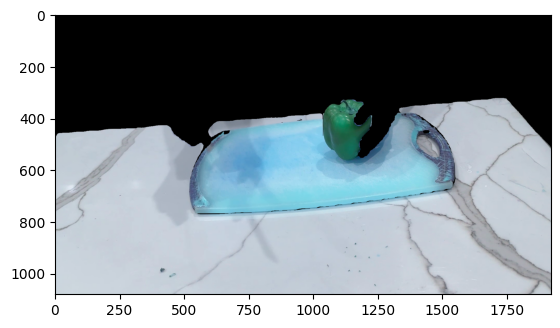

In [126]:
print(masked_frame_np.shape)
plt.imshow(masked_frame_np)

In [54]:
frame = cv2.imread("../images/current_vid_0.jpg")
# images = create_mask_images(frame, masks)
images = create_mask_images(frame, filtered_masks)

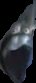

In [57]:
display(images[8])

In [43]:
reference_embeddings = []
reference_patch_embeddings = []

for i, points in enumerate(frames[1:3]):
    point = points[0]
    frame_num, fingers_point, wrist_point = point
    save_path = f"segmentation/images/current_vid_{str(i)}.jpg"
    frame = save_frame_as_image("segmentation/videos/IMG_3288.MOV", frame_num, save_path, fingers_point)
    # point_input = f"[[{str(fingers_point[0])},{str(fingers_point[1])}], [{str(wrist_point[0])},{str(wrist_point[1])}]]"
    # masks, embeddings = get_obj_embeddings(save_path, point=point_input, point_label="[1, 0]")
    
    masks = get_obj_masks(save_path)

    # find closest mask
    finger_point_tensor = torch.tensor([fingers_point[0], fingers_point[1]])
    sorted_masks = sort_masks_by_interaction(finger_point_tensor, masks)

    embedding = get_obj_embeddings(save_path, sorted_masks[0:1])
    cls_embedding = embedding[:, 0, :].squeeze()

    reference_embeddings.append(cls_embedding)
    reference_patch_embeddings.append(embedding[:, 1:, :].squeeze())

    # output frame of two closest masks unioned 
    # frame = cv2.imread(save_path)
    # union_mask = torch.logical_or(sorted_masks[0], sorted_masks[0])
    # mask_np = union_mask.cpu().numpy().astype(np.uint8) * 255
    # masked_frame = cv2.bitwise_and(frame, frame, mask=mask_np)

    masked_frame = create_mask_images(frame, sorted_masks[0:1])[0]
    masked_frame_np = np.array(masked_frame)

    output_path = f"./output/current_vid_{str(i)}.jpg"
    cv2.imwrite(output_path, masked_frame_np)
    # cv2.imwrite(output_path, cv2.cvtColor(masked_frame_np, cv2.COLOR_RGB2BGR))

    # if masks is None:
    #     pass

reference_embeddings = torch.stack(reference_embeddings)
reference_patch_embeddings = torch.stack(reference_patch_embeddings)


0: 576x1024 34 objects, 24136.8ms
Speed: 231.3ms preprocess, 24136.8ms inference, 2393.6ms postprocess per image at shape (1, 3, 1024, 1024)


torch.Size([14, 1080, 1920])



0: 576x1024 37 objects, 11620.7ms
Speed: 29.2ms preprocess, 11620.7ms inference, 1889.6ms postprocess per image at shape (1, 3, 1024, 1024)


torch.Size([15, 1080, 1920])


In [11]:
query_img = save_frame_as_image("segmentation/videos/IMG_3289.MOV", 30, "segmentation/images/query_img.jpg")

In [44]:
query_masks = get_obj_masks('segmentation/images/query_img.jpg', filter=False)


0: 544x1024 28 objects, 14758.1ms
Speed: 29.1ms preprocess, 14758.1ms inference, 1319.7ms postprocess per image at shape (1, 3, 1024, 1024)


torch.Size([28, 970, 1834])


In [45]:
query_embeddings = get_obj_embeddings('segmentation/images/query_img.jpg', query_masks)
query_patch_embeddings = query_embeddings[:, 1:, :]
query_embeddings = query_embeddings[:, 0, :].squeeze()

In [49]:
print(query_embeddings.shape)
print(query_patch_embeddings.shape)
print(reference_patch_embeddings.shape)

torch.Size([28, 768])
torch.Size([28, 256, 768])
torch.Size([2, 256, 768])


In [72]:
def sim_matrix(a, b, eps=1e-8):
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt


similarities = sim_matrix(query_embeddings, reference_embeddings)
matched_query_masks_idx = torch.argmax(similarities, dim=0)
matched_query_masks = query_masks[matched_query_masks_idx, :, :]
matched_query_patch_embeddings = query_patch_embeddings[matched_query_masks_idx, :, :]
print(matched_query_patch_embeddings.shape)

NameError: name 'query_embeddings' is not defined

In [51]:
query_img = cv2.imread("segmentation/images/query_img.jpg")
for i in range(matched_query_masks.shape[0]):
    masked_frame = create_mask_images(query_img, matched_query_masks[i:i+1])[0]
    masked_frame_np = np.array(masked_frame)

    output_path = f"./output/query_img_{str(i)}.jpg"
    cv2.imwrite(output_path, masked_frame_np)

In [107]:
def find_similar_patch(ref_img, query_img, ref_patches, query_patches, ref_point, num_patches=16):
    # find what ref patch point is in
    H, W, _ = ref_img.shape
    divH = H * 1.0 / num_patches
    divW = W * 1.0 / num_patches
    patch_row_idx = int(ref_point[0] // divH)
    patch_col_idx = int(ref_point[1] // divW)
    print(patch_row_idx, patch_col_idx)

    ref_patches = ref_patches.squeeze().view(16, 16, -1)
    query_patches = query_patches.squeeze().view(16, 16, -1)

    # calculate euclidean distance
    patch_embedding = ref_patches[patch_row_idx, patch_col_idx, :]
    patch_embedding = patch_embedding.view(1, 1, -1)
    squared_diff = (query_patches - patch_embedding) ** 2
    dist = torch.sqrt(torch.sum(squared_diff, dim=2))

    # closest patch in query image
    min_idx = torch.argmin(dist)
    min_row_idx = (min_idx // num_patches).item()
    min_col_idx = (min_idx % num_patches).item()
    print(min_row_idx, min_col_idx)

    dist_inverted = dist - torch.min(dist)
    dist_inverted = 1 - dist_inverted/torch.max(dist_inverted)
    divH_q = query_img.shape[0] * 1.0 / num_patches
    divW_q = query_img.shape[1] * 1.0 / num_patches

    best_query_point = [int((min_row_idx + 0.5) * divH_q), int((min_col_idx + 0.5) * divW_q)]

    # overlay heatmap 
    heatmap = np.zeros_like(query_img)

    for i in range(num_patches):
        for j in range(num_patches):
            heatmap[int(i*divH_q):int((i + 1)*divH_q), int(j*divW_q):int((j + 1)*divW_q)] = 255 * dist_inverted[i, j].detach().numpy()

    heatmap[heatmap <= 255 * 0.9] = 0
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(query_img, 0.7, heatmap, 0.3, 0)

    fig, axes = plt.subplots(1, 2)

    cv2.circle(overlay, best_query_point[::-1], 10, (255, 255, 255), 2)
    axes[0].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    axes[0].axis('off')

    cv2.circle(ref_img, ref_point[::-1], 10, (255, 0, 0), 2)
    axes[1].imshow(cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB))
    axes[1].axis('off')

    plt.show()

    return best_query_point, heatmap



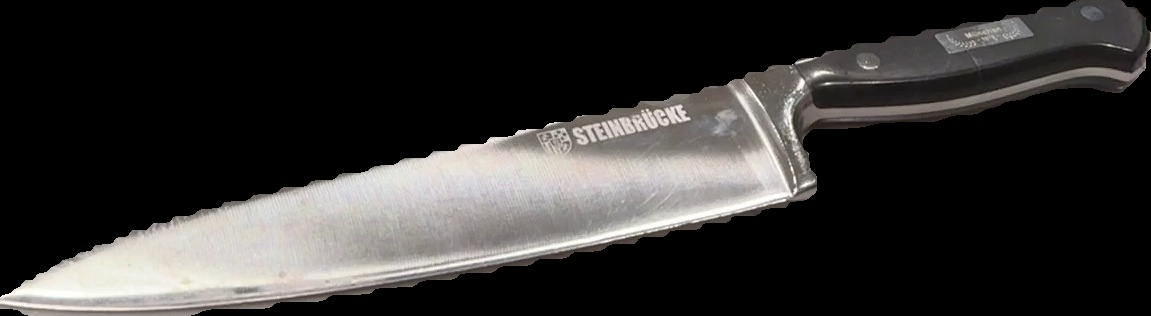

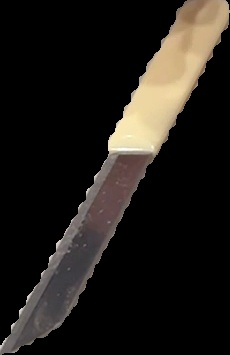

In [160]:
import urllib

import io
import numpy as np
from PIL import Image

query_image = Image.open("./output/query_img_0.jpg")
ref_image = Image.open("./output/current_vid_0.jpg")
display(query_image)
display(ref_image)

In [173]:
from typing import Tuple

import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import torch
import torchvision.transforms as transforms


REPO_NAME = "facebookresearch/dinov2"
MODEL_NAME = "dinov2_vitb14"


DEFAULT_SMALLER_EDGE_SIZE = 448
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

def zero_pixel(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    val = mean[0] / std[0] + mean[1] / std[1] + mean[2]/std[2]
    return -1 * val

def make_transform(smaller_edge_size: int) -> transforms.Compose:
    IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
    IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
    interpolation_mode = transforms.InterpolationMode.BICUBIC

    return transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=interpolation_mode, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ])


def prepare_image(image: Image,
                  smaller_edge_size: float,
                  patch_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    transform = make_transform(int(smaller_edge_size))
    image_tensor = transform(image)
    resize_scale = image.width / image_tensor.shape[2]

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % patch_size, height - height % patch_size
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // patch_size, cropped_width // patch_size) # h x w (TODO: check)
    return image_tensor, grid_size, resize_scale


def make_foreground_mask(image_tensor):
    mask = torch.sum(image_tensor, dim=0)
    threshold = zero_pixel()
    mask = (torch.abs(mask - threshold) > 0.001).int()
    new_size = (mask.size(0) // 14, mask.size(1) // 14)
    resized_mask = torch.empty(new_size, dtype=torch.bool)
    for i in range(new_size[0]):
        for j in range(new_size[1]):
            ones = torch.sum(mask[i*14:(i+1)*14, j*14:(j+1)*14])
            if ones <= (14 * 14 * 0.8):
                resized_mask[i, j] = False
            else:
                resized_mask[i, j] = True
    
    mask = resized_mask.flatten()
    return mask.flatten()


def render_patch_pca(ref_image: Image,
                     query_image: Image,
                     smaller_edge_size: float = 448,
                     patch_size: int = 14):
    
    ref_image_tensor, ref_grid_size, ref_scale = prepare_image(ref_image, smaller_edge_size, patch_size)
    query_image_tensor, query_grid_size, query_scale = prepare_image(query_image, smaller_edge_size, patch_size)

    print("image shape: ", end="")
    print(ref_image_tensor.shape, query_image_tensor.shape)

    ref_mask = make_foreground_mask(ref_image_tensor)
    query_mask = make_foreground_mask(query_image_tensor)

    print("mask shape: ", end="")
    print(ref_mask.shape, query_mask.shape)

    with torch.inference_mode():
        ref_tokens = model.get_intermediate_layers(ref_image_tensor.unsqueeze(0))[0].squeeze()
        query_tokens = model.get_intermediate_layers(query_image_tensor.unsqueeze(0))[0].squeeze()
        # tokens = model(image_batch)

    print("tokens shape: ", end="")
    print(ref_tokens.shape, query_tokens.shape)

    masked_tokens = torch.cat([ref_tokens[ref_mask], query_tokens[query_mask]], dim=0)

    pca = PCA(n_components=3)
    pca.fit(masked_tokens)
    projected_ref_tokens = pca.transform(ref_tokens)
    projected_query_tokens = pca.transform(query_tokens)

    t = torch.tensor(projected_ref_tokens)
    t_min = t.min(dim=0, keepdim=True).values
    t_max = t.max(dim=0, keepdim=True).values
    normalized_t = (t - t_min) / (t_max - t_min)

    array = (normalized_t * 255).byte().numpy()
    array[~ref_mask] = 0
    array = array.reshape(*ref_grid_size, 3)
    ref_pca_img = Image.fromarray(array).resize((ref_image.width, ref_image.height), 0)

    t = torch.tensor(projected_query_tokens)
    t_min = t.min(dim=0, keepdim=True).values
    t_max = t.max(dim=0, keepdim=True).values
    normalized_t = (t - t_min) / (t_max - t_min)

    array = (normalized_t * 255).byte().numpy()
    array[~query_mask] = 0
    array = array.reshape(*query_grid_size, 3)
    query_pca_img = Image.fromarray(array).resize((query_image.width, query_image.height), 0)

    return ref_pca_img, query_pca_img, ref_tokens, query_tokens, ref_mask, query_mask, ref_grid_size, query_grid_size, ref_scale, query_scale



print(f"using {MODEL_NAME} model")
model = torch.hub.load(repo_or_dir=REPO_NAME, model=MODEL_NAME)
model.eval()
print(f"patch size: {model.patch_size}")

ref_pca_img, query_pca_img, ref_tokens, query_tokens, ref_mask, query_mask, ref_grid_size, query_grid_size, ref_scale, query_scale = render_patch_pca(ref_image=ref_image,
                                                                                                                                        query_image=query_image,
                                                                                                                                        smaller_edge_size=DEFAULT_SMALLER_EDGE_SIZE,
                                                                                                                                        patch_size=model.patch_size)

using dinov2_vitb14 model


Using cache found in C:\Users\arshs/.cache\torch\hub\facebookresearch_dinov2_main


patch size: 14
image shape: torch.Size([3, 686, 448]) torch.Size([3, 448, 1624])
mask shape: torch.Size([1568]) torch.Size([3712])
tokens shape: torch.Size([1568, 768]) torch.Size([3712, 768])


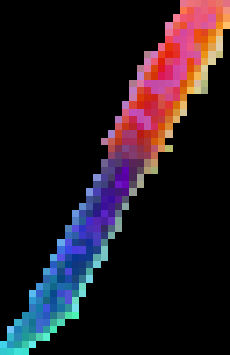

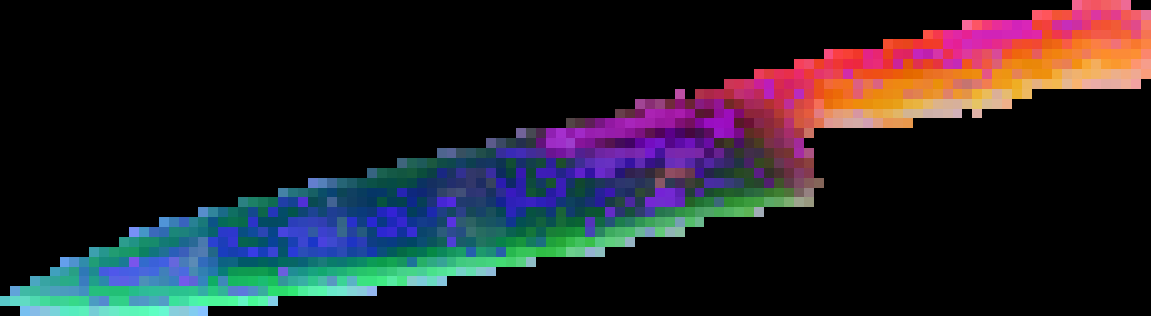

In [172]:
display(ref_pca_img)
display(query_pca_img)

In [216]:
def source_position_to_idx(row, col, grid_size, resize_scale):
    idx = ((row / resize_scale) // (14)) * grid_size[1] + ((col / resize_scale) // (14))
    return int(idx)

def idx_to_source_position(idx, grid_size, resize_scale):
    row = (idx // grid_size[1])*14*resize_scale + 14 / 2
    col = (idx % grid_size[1])*14*resize_scale + 14 / 2
    return int(row), int(col)

def closest_embedding(ref_embedding, query_embeddings, query_mask):
    distances = torch.norm(query_embeddings - ref_embedding, dim=1)
    dist_copy = distances.clone()
    distances[~query_mask] = float('inf')
    return torch.argmin(distances).item(), dist_copy

def generate_heatmap(distances, mask, grid_size, image_size):
    distances = distances.reshape(grid_size)
    mask = mask.reshape(grid_size)
    heatmap_np = distances.numpy()
    heatmap_np *= -1
    heatmap_np = (heatmap_np - np.min(heatmap_np)) / (np.max(heatmap_np) - np.min(heatmap_np))
    heatmap_np[~mask] = 0

    cmap = plt.get_cmap('jet')
    heatmap = cmap(heatmap_np)
    heatmap_rgb = (heatmap[:, :, :3] * 255).astype(np.uint8)
    resized_heatmap = cv2.resize(heatmap_rgb, (image_size[0], image_size[1]))
    
    return resized_heatmap

contact_pt = [61, 198]
idx = source_position_to_idx(contact_pt[0], contact_pt[1], ref_grid_size, ref_scale)
matched_idx, distances = closest_embedding(ref_tokens[idx, :], query_tokens, query_mask)
heatmap = generate_heatmap(distances, query_mask, query_grid_size, query_pca_img.size)
row, col = idx_to_source_position(matched_idx, query_grid_size, query_scale)


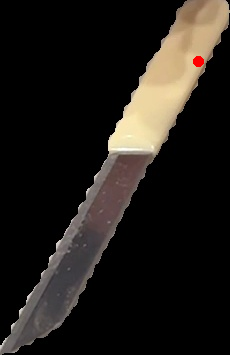

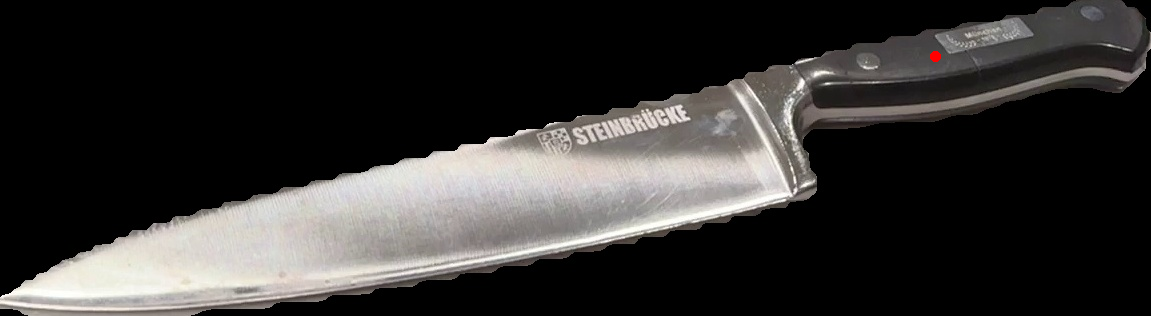

In [213]:
from PIL import ImageDraw

query_image = Image.open("./output/query_img_0.jpg")
ref_image = Image.open("./output/current_vid_0.jpg")

draw = ImageDraw.Draw(query_image)
draw.ellipse([col-5, row-5, col+5, row+5], fill=(255, 0, 0))

draw = ImageDraw.Draw(ref_image)
draw.ellipse([contact_pt[1]-5, contact_pt[0]-5, contact_pt[1]+5, contact_pt[0]+5], fill=(255, 0, 0))

display(ref_image)
display(query_image)

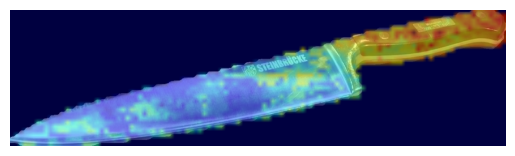

In [218]:
query_image = Image.open("./output/query_img_0.jpg")

overlay = cv2.addWeighted(np.array(query_image), 0.5, heatmap, 0.5, 0)

plt.imshow(overlay)
plt.axis('off')
plt.show()